In [1]:
import os
from operator import add
from typing import Literal
from typing import Annotated
from pydantic import BaseModel
from dotenv import load_dotenv
from google.cloud import bigquery
from langchain_groq import ChatGroq
from langchain.schema import Document
from typing_extensions import TypedDict
from google.oauth2 import service_account
from langchain_community.vectorstores import FAISS
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate
from langchain.document_loaders import DataFrameLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

In [2]:
%pwd

'f:\\College\\Masters\\Semesters\\Fall 2024\\MLOps\\eCom-chat\\notebooks'

In [3]:
os.chdir('../')

In [4]:
load_dotenv()

True

In [5]:
## load the API Keys
os.environ['HF_TOKEN']=os.getenv("HF_TOKEN")
os.environ['OPENAI_API_KEY']=os.getenv("OPENAI_API_KEY")
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")
os.environ['LANGFUSE_PUBLIC_KEY']=os.getenv("LANGFUSE_PUBLIC_KEY")
os.environ['LANGFUSE_SECRET_KEY']=os.getenv("LANGFUSE_SECRET_KEY")
os.environ['LANGFUSE_HOST']=os.getenv("LANGFUSE_HOST")

In [6]:
from langfuse.callback import CallbackHandler

langfuse_handler = CallbackHandler(
    public_key=os.environ['LANGFUSE_PUBLIC_KEY'],
    secret_key=os.environ['LANGFUSE_SECRET_KEY'],
    host=os.environ['LANGFUSE_HOST']
)

In [7]:
REVIEW_TABLE = "ecom-chat-437005.ecom_chat.review"
META_TABLE = "ecom-chat-437005.ecom_chat.meta"
PARENT_ASIN = '0156031191'

## Connect Big Query

In [11]:
credentials = service_account.Credentials.from_service_account_file(
    'src/big_credentials.json')
client = bigquery.Client(credentials=credentials)

In [15]:
# Perform a review query.
review_query = (f'''SELECT *
         FROM {REVIEW_TABLE} 
         WHERE parent_asin='0156031191'
         ''')
query_job = client.query(review_query)  # API request
review = query_job.result()  # Waits for query to finish

In [16]:
review_df = review.to_dataframe()

In [12]:
# Perform a metadata query.
meta_query = (f'''SELECT *
         FROM {META_TABLE} 
         WHERE parent_asin='{PARENT_ASIN}'
         ''')
query_job = client.query(meta_query)  # API request
meta = query_job.result()  # Waits for query to finish

In [13]:
meta_df = meta.to_dataframe()

f:\College\Masters\Semesters\Fall 2024\MLOps\eCom-chat\verta\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
f:\College\Masters\Semesters\Fall 2024\MLOps\eCom-chat\verta\Lib\site-packages\google\cloud\bigquery\_pandas_helpers.py:207: UserWarning: Unable to determine Arrow type for field 'images'.
  warnings.warn(


## Loading the Review Data

In [17]:
review_df.drop(columns=['user_id', 'images'], inplace = True)
meta_df.drop(columns=['images', 'videos', 'bought_together'], inplace = True)

In [18]:
# Create a DataFrameLoader instance
loader = DataFrameLoader(review_df) 

# Load the documents
review_documents = loader.load()

## Create LangGraph Workflow

In [19]:
class MultiAgentState(TypedDict):
    question: str
    documents: Annotated[list[str], add]
    question_type: str
    answer: str 
    followup_questions: list[str]

In [20]:
members = ["Metadata", "Review-Vectorstore"]
system_prompt = (
    '''
    You are an efficient supervisor responsible for overseeing a conversation between the following agents: {members}. 

    If you got response from the Agent (response given below as "Generated Answer from the Agents:"), respond with 'FINISH' to move on to next step. 
    
    Based on the user's request, decide which agent should respond next. Each agent will complete a task and return their result. 
    
    There are two agents working alongside you:
        - Metadata: This agent has all metadata information about that product. 
        - Review-Vectorstore: This is a FAISS Vectorstore db containing documents related to all the user reviews for that product.
    
    If you got unsatisfied response from the Agents (Agent Throwing Errors like: "Metadata: Unable to generate result") ONLY THEN Call an Agent a **MAXIMUM of TWO TIMES** before responding with 'FINISH'.
    Once sufficient information is obtained from the Agents, respond with 'FINISH', after which Alpha, the final assistant, will provide the concluding guidance to the user.
    If the query is generic (Hello, How are you, etc) then route it to Alpha and respond with 'FINISH.' 

    If you got satisfactory response from the Agent (response given above), respond with 'FINISH' to move on to next step. 
    '''
)

# Our team supervisor is an LLM node. It just picks the next agent to process and decides when the work is completed
options = ["FINISH"] + members

In [21]:
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal[*options] 

In [22]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ('system', "Generated Answer from the Agents: {document}"),
        ("human", "{question}"),
        (
            "system",
            "Given the conversation above, who should act next?"
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model_name="gpt-4o-mini")
def supervisor_agent(state: MultiAgentState):
    question = state["question"]
    document = state["documents"]
    supervisor_chain = prompt | llm.with_structured_output(RouteQuery)
    update_documents = [m for m in document[-5:]]
    return {'question_type' : supervisor_chain.invoke({"question": question, 'document': document}), 'question': question, 'documents': update_documents}

In [23]:
def route_question(state):
    print("---ROUTE QUESTION---")
    source = state['question_type']
    if source.datasource == "Metadata":
        print("---ROUTE QUESTION TO METADATA---")
        return "Metadata"
    elif source.datasource == "Review-Vectorstore":
        print("---ROUTE QUESTION TO FAISS---")
        return "Review-Vectorstore"
    elif source.datasource == "FINISH":
        print("---ROUTE QUESTION TO ALPHA---")
        return "FINISH"

In [24]:
def metadata_node(state: MultiAgentState):
    meta_llm = ChatGroq(model_name="llama-3.1-8b-instant")

    modified_details = meta_df['details'].astype(str).str.replace('{', '[')
    
    # Answer question
    meta_system_prompt =( 
        f'''
        You are a great Data Interpreter and Summarizer. Read the Product Meta Data sent to you and Produce it in 500 words.
        
        Meta Data:
        main_category: {(meta_df.at[0,'main_category'])}
        title: {(meta_df.at[0, 'title'])}
        average_rating: {(meta_df.at[0, 'average_rating'])}
        rating_number: {(meta_df.at[0, 'rating_number'])}
        features: {(meta_df.at[0, 'features'])}
        description: {(meta_df.at[0, 'description'])}
        price: {(meta_df.at[0, 'price'])}
        store: {(meta_df.at[0, 'store'])}
        categories: {(meta_df.at[0, 'categories'])}	
        details: {(modified_details.at[0])}

        Return in a proper format:
        main_category: Same 
        title: Same
        average_rating: Same
        rating_number: Same
        features: Summarize	
        description: Summarize
        price: Same
        store: Same	
        categories: Same	
        details: Same/Summarize where necessary	

        Do not answer any user question, just provide the meta data
        '''
    )

    meta_system_prompt = meta_system_prompt.replace('{', '{{').replace('}', '}}')

    meta_qa_prompt = ChatPromptTemplate.from_messages(
                    [
                        ("system", meta_system_prompt),
                    ]
                )
    parser = StrOutputParser()
    meta_chain = meta_qa_prompt | meta_llm | parser

    try:
        # Meta Summary
        meta_results = meta_chain.invoke({'input': ''})
        meta_results = Document(page_content=meta_results, metadata={"source": "Metadata"})
        
    except Exception as error:
        print(error)
        content = "Metadata: Unable to generate result"
        meta_results = Document(page_content=content, metadata={"source": "Metadata"})

    return {'documents': [meta_results], "question": state["question"]}

In [25]:
def retrieve(state: MultiAgentState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    vectordb = FAISS.from_documents(documents=review_documents, embedding=embeddings)
    

    retriever = vectordb.as_retriever()
    # Retrieval
    documents = retriever.invoke(question)

    return {"documents": documents, "question": question}

In [26]:
def final_llm_node(state: MultiAgentState):
    question = state["question"]
    documents = state["documents"]

    model = ChatGroq(model_name="llama-3.1-70b-versatile")
    system_prompt = (
        f'''
        You are Alpha, a highly knowledgeable and efficient chatbot assistant designed to help users with questions related to products.
        Your primary role is to assist users by providing concise, accurate, and insightful responses based on the product information and reviews available to you.
        If you don’t have the necessary information to answer the question, simply say that you don’t know.

        There are two agents working alongside you:
        - Metadata: This agent provides answers related to a product. It has all the information about that product.
        - Review-Vectorstore: This is a FAISS Vectorstore db containing documents related to all the user reviews for one product.
        
        When a User (Shopper) comes to you for help, the question might have first been routed through either the Metadata or the Review-Vectorstore. 

        Your primary objective is to offer clear, concise, and helpful advice to the teacher, ensuring that they receive the most accurate and useful information to support their shopping needs.

        Instructions:
        - Analyze the product information and/or reviews provided.
        - Provide brief, clear, and helpful answers to user queries about the product.
        - Focus on delivering concise and actionable insights to help users make informed decisions.

        The responses from those agents are available to you, and if their answers were incomplete or unsatisfactory, you will find this reflected in the context field. 
        Your job is to analyze their responses, determine if they are adequate, and provide additional guidance or clarification where needed.
        Below is the context from one of the agents:
        '''
        "{context}"
    )

    qa_prompt = ChatPromptTemplate.from_messages(
                    [
                        ("system", system_prompt),
                        ("human", "{input}")
                    ]
                )
    question_answer_chain = qa_prompt | model

    generation = question_answer_chain.invoke({"context": documents, "input": question})

    return {"documents": documents, "question": question, "answer": generation}

In [27]:
def followup_node(state: MultiAgentState):
    documents = state['documents']
    question = state['question']
    answer = state['answer']
    
    model = ChatGroq(model_name="llama-3.1-8b-instant")
    system_prompt = (
        '''
        Given the following:
        User Question: {question}
        Answer: {answer}
        Context: {context}
        Please generate three possible follow-up questions that the user might ask, each on a new line, without any numbering or bullet points. Do not include any explanations—just list the follow-up questions.
        Format them like this:
        question1\nquestion2\nquestion3
        '''
    )       
    follow_prompt = ChatPromptTemplate.from_messages(
                    [
                        ("system", system_prompt),
                    ]
                )
    
    followup_chain = follow_prompt | model
    followup = followup_chain.invoke({'question': question, 'answer': answer, 'context': documents[-2:]}) # just consider last two document list 
    followup_questions = followup.content.split('\n')
    
    return {"question": question, "answer": answer, "documents": documents, 'followup_questions': followup_questions}       

In [28]:
memory = MemorySaver()
builder = StateGraph(MultiAgentState)
builder.add_node("Metadata", metadata_node)
builder.add_node("Review-Vectorstore", retrieve)
builder.add_node("supervisor", supervisor_agent)
builder.add_node("generate", final_llm_node)
builder.add_node("final", followup_node)

for member in members:
    builder.add_edge(member, "supervisor")
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = 'generate'

builder.add_conditional_edges("supervisor", route_question, conditional_map)

builder.add_edge(START, "supervisor")
builder.add_edge("generate", "final")
builder.add_edge("final", END)

app = builder.compile(checkpointer=memory)

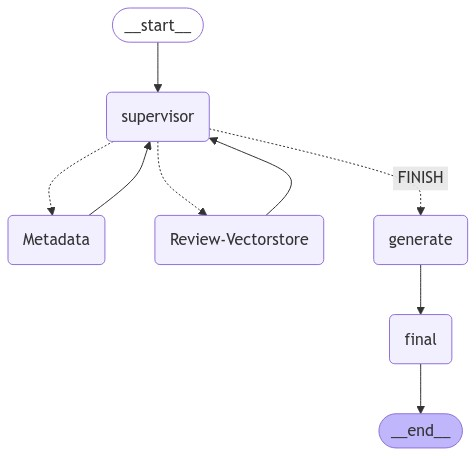

In [29]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [30]:
config = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}
inputs = {"question": "What is the product dimension?"}
for output in app.stream(inputs, config=config):
    if 'final' in output:
        print("Question:")
        print(output['final']['question'])
        print("Answer:")
        print(output['final']['answer'].content)
        print("Followup-Questions:")
        print(output['final']['followup_questions'])

---ROUTE QUESTION---
---ROUTE QUESTION TO METADATA---
---ROUTE QUESTION---
---ROUTE QUESTION TO ALPHA---
Question:
What is the product dimension?
Answer:
According to the product metadata, the dimensions of the book "Winter's Tale" are 5.31 x 1.76 x 8 inches.
Followup-Questions:
["What are the book's ISBN numbers?", 'Is the book in paperback format?', 'What is the total weight of the book including the packaging?']


In [30]:
config = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}
inputs = {"question": "How are the reviews?"}
for output in app.stream(inputs, config=config):
    if 'final' in output:
        print("Question:")
        print(output['final']['question'])
        print("Answer:")
        print(output['final']['answer'].content)
        print("Followup-Questions:")
        print(output['final']['followup_questions'])

---ROUTE QUESTION---
---ROUTE QUESTION TO FAISS---
---RETRIEVE---


f:\College\Masters\Semesters\Fall 2024\MLOps\eCom-chat\verta\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


<class 'langchain_core.vectorstores.base.VectorStoreRetriever'>
---ROUTE QUESTION---
---ROUTE QUESTION TO FAISS---
---RETRIEVE---
<class 'langchain_core.vectorstores.base.VectorStoreRetriever'>
---ROUTE QUESTION---
---ROUTE QUESTION TO FAISS---
---RETRIEVE---
<class 'langchain_core.vectorstores.base.VectorStoreRetriever'>
---ROUTE QUESTION---
---ROUTE QUESTION TO FAISS---
---RETRIEVE---
<class 'langchain_core.vectorstores.base.VectorStoreRetriever'>
---ROUTE QUESTION---
---ROUTE QUESTION TO FAISS---
---RETRIEVE---
<class 'langchain_core.vectorstores.base.VectorStoreRetriever'>
---ROUTE QUESTION---
---ROUTE QUESTION TO FAISS---
---RETRIEVE---
<class 'langchain_core.vectorstores.base.VectorStoreRetriever'>
---ROUTE QUESTION---
---ROUTE QUESTION TO FAISS---
---RETRIEVE---
<class 'langchain_core.vectorstores.base.VectorStoreRetriever'>
---ROUTE QUESTION---
---ROUTE QUESTION TO FAISS---
---RETRIEVE---
<class 'langchain_core.vectorstores.base.VectorStoreRetriever'>
---ROUTE QUESTION---
---RO

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

: 